# Amazon product catalog: understanding ratings


## Problem scope

Can Amazon reviews help predict the product rating?

## Open prospective questions / workflow

1. Predict the rating based on item desc. and other facets: regression w/ language data

2. How well reviewed something is ties in with the rating.

3. Figure out product, product contents, product tags, document per row + brand + company type, product category, description (pulled out of scope).

4. Probability that the thing we labeled is actually in that class? (out of scope now) 


## Data imports

### Libraries

In [1]:
#basic ops
import pandas as pd, numpy as np, matplotlib.pyplot as plt, \
                 seaborn as sns, re

#other helper functions
from pandasql import sqldf

#show grid on plots
sns.set_style('darkgrid')

#display tables without ellipsis
#pd.set_option('display.max_rows', 200)

### Product dataset

In [2]:
#import ecom dataset
ecom = pd.read_csv('../data/amazon_co-ecommerce_sample.csv')

In [3]:
#check data size
ecom.shape

(10000, 17)

In [4]:
#check data types
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      10000 non-null  object 
 1   product_name                                 10000 non-null  object 
 2   manufacturer                                 9993 non-null   object 
 3   price                                        8565 non-null   object 
 4   number_available_in_stock                    7500 non-null   object 
 5   number_of_reviews                            9982 non-null   object 
 6   number_of_answered_questions                 9235 non-null   float64
 7   average_review_rating                        9982 non-null   object 
 8   amazon_category_and_sub_category             9310 non-null   object 
 9   customers_who_bought_this_item_also_bought   8938 non-null   object 
 10 

In [5]:
#peek at dataframe
ecom.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,NaN,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN


## Cleaning

Let's clean up our columns, including price, so that they can converge properly.

### Remove extraneous characters

From the pound signs in the prices, to prices listed as ranges, we have some issues in our data formats. Let's fix these.

For price ranges, I will merely consume the lower bound of the price.

Since inventory is not really part of our problem statement, we can leave it alone.

In [6]:
#Substantial datatype conversion help here from https://pbpython.com/currency-cleanup.html

def clean_price(x):
    
    if isinstance(x, str):
#If the value is a string, then remove currency symbol, delimiters and anything 
#else following the price; otherwise, the value is numeric and can be converted as is.
        
        return(x.replace('£', '').replace(',', '').split(' - ')[0])
    #strip price of the pound sign
    #we need to get rid of price ranges. I will just consume the LOWER BOUND in case of a price range.

    return(x)

In [7]:
#apply my price function to convert the price column type
ecom['price'] = ecom['price'].apply(clean_price).astype('float')

In [8]:
#strip out "out of 5 stars" from average_review_rating
ecom['average_review_rating'] = ecom['average_review_rating'].str.strip(
    ' out of 5 stars').astype(float)

#verify
ecom['average_review_rating'].head(2)

0    4.9
1    4.0
Name: average_review_rating, dtype: float64

In [9]:
#strip out commas from number_of_reviews column
ecom['number_of_reviews'] = ecom['number_of_reviews'].str.replace(",", "")

#verify number of reviews column
ecom['number_of_reviews'].sort_values(ascending=False)[:30]

3182    99
7179    99
1541    98
6616    98
133     97
4153    97
9434    97
6642    96
6552    96
3305    95
5166    95
6878    95
7183    95
1678    94
9476    94
6066    93
792     92
664     92
1812    92
7326    92
9441    91
4280    91
7422    91
9830    91
7219    91
9945    91
3840    90
4688     9
2207     9
159      9
Name: number_of_reviews, dtype: object

In [10]:
#double check that our digits converted correctly
ecom.loc[ecom['number_of_reviews']=='1040']

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
8872,c751a76dd7668f78b4222b5547e7249b,TOMY Pop-Up Pirate,Tomy,9.99,59 new,1040,11.0,4.0,Characters & Brands > Tomy,http://www.amazon.co.uk/Hungry-Hippos-Elefun-F...,Style Name:Pop-Up-Pirate/T7028 Product Descrip...,Technical Details Brand Tomy Model NumberT7028...,Style Name:Pop-Up-Pirate/T7028 Product Descrip...,NaN,Is this good for 5 and 6 year old kids? // Hi ...,Crazy fun // 4.0 // 9 Sept. 2007 // By\n \n...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."


### Converting object columns to numeric where applicable

We had 4 columns originally that seemed like good candidates for conversion to numeric:

* price
* number_of_reviews
* number_of_answered_questions
* average_review_rating

In [11]:
#force num type on number_of_reviews, number_of_answered_questions, price, average_review_rating
ecom['number_of_answered_questions'] = ecom[
    ['number_of_answered_questions']].apply(pd.to_numeric)

In [12]:
#convert reviews - must first remove nulls for this to work
ecom.dropna(subset=['number_of_reviews'], inplace=True)

#convert
ecom['number_of_reviews'] = ecom['number_of_reviews'].astype(int)

In [13]:
#confirm conversions
ecom.dtypes

uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                          float64
number_available_in_stock                       object
number_of_reviews                                int64
number_of_answered_questions                   float64
average_review_rating                          float64
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
dtype: object

### Convert price

A nuance observed here is that we have a complicating issue in our data set in that some prices are displayed as ranges.

There were two places where we could look at price: the price column, which we have now reduced to the lower bound for simplicity, as well as the seller column.

One way to think of the price variability is that each seller can charge a different price. However, the wild variability can also be explained by product condition.

For simplicity, we are going to look at the average price, and create a new column we can reuse, with that information:

In [14]:
#Gwen's code -- map avg. price to column

def median_sale_price(x):
    if pd.isna(x):
        return np.nan
    
    try:
        return np.median(
            [float(y.split('"')[0]) for y in list(x.split('£')[1:])])
    
    except:
        nos = []
        for y in list(x.split('£')[1:]):
            try:
                nos.append(float(y.split('"')[0]))
            except:
                pass
        return np.median(nos)
    
ecom['median_sale_price'] = ecom['sellers'].map(median_sale_price)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Prepare text

We need to remove punctuation and other noise from our text.

In [15]:
#remove line breaks and other junk from review and customer q's columns

#ecom.replace(
#    to_replace=[r"\\t|\\n|\\r|//", "\t|\n|\r"], value=["",""],
#    regex=True, inplace=True)

#ecom['customer_reviews'].replace(
#    r'[^a-zA-Z0-9]', ' ', regex=True, inplace=True)

ecom['customer_reviews'] = ecom['customer_reviews'].str.replace('|','')

ecom['customer_reviews'] = ecom['customer_reviews'].str.replace('//','')

ecom['customer_reviews'] = ecom['customer_reviews'].str.replace('\\n','')

### Imputing nulls

For some of the fields, imputing with a 0 for numeric columns seems to make sense -- no reviews is no different than 0 reviews. For string / object columns we were unable to convert, we will fill with an empty string to avoid issues later on.

For price, however, we'll want to impute with the mean, now that we've successfully converted it to numeric. And we will do the same for the average review rating.

In [16]:
#initial null count
ecom.isnull().sum()

uniq_id                                           0
product_name                                      0
manufacturer                                      7
price                                          1432
number_available_in_stock                      2497
number_of_reviews                                 0
number_of_answered_questions                    764
average_review_rating                             0
amazon_category_and_sub_category                684
customers_who_bought_this_item_also_bought     1062
description                                     647
product_information                              58
product_description                             647
items_customers_buy_after_viewing_this_item    3058
customer_questions_and_answers                 9069
customer_reviews                                  3
sellers                                        3080
median_sale_price                              3082
dtype: int64

In [17]:
#fill price with average of column
ecom['price'] = ecom['price'].fillna(
    ecom['price'].mean())

ecom['median_sale_price'] = ecom['median_sale_price'].fillna(
    ecom['median_sale_price'].mean())

In [18]:
#fill blank ratings with mean
ecom['average_review_rating'] = ecom['average_review_rating'].fillna(
    ecom['average_review_rating'].mean())

#ecom.dropna(
#    subset=['average_review_rating'], inplace=True)

#check ratings data now
ecom['average_review_rating'].value_counts()

0.0    5140
4.0    2030
4.8     567
4.7     528
4.3     407
4.6     392
4.4     298
4.9     237
4.2     217
4.1     145
3.9       7
3.0       5
3.6       3
3.7       2
3.3       2
3.8       1
2.3       1
Name: average_review_rating, dtype: int64

In [19]:
#fill remaining empty num cols w/ 0's:
ecom['number_of_answered_questions'] = ecom[
    'number_of_answered_questions'].fillna(0)

In [20]:
#fill in NaN's with '' for everything else non-num;
ecom = ecom.fillna('')
ecom.head(3)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,median_sale_price
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,3.42,5 new,15,1.0,4.9,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",8.000
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,16.99,,2,1.0,4.0,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars 4.0 18 Dec. 2015 By kenne...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.990
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,9.99,2 new,17,2.0,3.9,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** 5.0 26 May 2015 By ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",19.945


In [21]:
#check what's left to impute
ecom.isnull().sum()

uniq_id                                        0
product_name                                   0
manufacturer                                   0
price                                          0
number_available_in_stock                      0
number_of_reviews                              0
number_of_answered_questions                   0
average_review_rating                          0
amazon_category_and_sub_category               0
customers_who_bought_this_item_also_bought     0
description                                    0
product_information                            0
product_description                            0
items_customers_buy_after_viewing_this_item    0
customer_questions_and_answers                 0
customer_reviews                               0
sellers                                        0
median_sale_price                              0
dtype: int64

## EDA

Interesting possible questions for exploration:

* Is there a correlation between number of reviews and number of questions?
* Is there a relationship between the number of sellers and the star rating?
* Is there a relationship between the star rating and the number of reviews?
* Is there a relationship between the product description and the star rating?
* Is there a relationship between a product being sold as new vs. used and its rating?
* Is there a relaionship between the product price and average rating?
* Do certain categories rank higher than others?

In [22]:
#what can we analyze, again?
ecom.columns

Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category',
       'customers_who_bought_this_item_also_bought', 'description',
       'product_information', 'product_description',
       'items_customers_buy_after_viewing_this_item',
       'customer_questions_and_answers', 'customer_reviews', 'sellers',
       'median_sale_price'],
      dtype='object')

What is the central tendency for the numeric columns in our dataset?

In [23]:
#look at central tendency
ecom.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
price,9982.0,20.27,42.91,0.01,5.95,12.99,20.27,2439.92
number_of_reviews,9982.0,9.14,33.73,1.00,1.00,2.00,6.00,1399.00
number_of_answered_questions,9982.0,1.69,2.47,0.00,1.00,1.00,2.00,39.00
average_review_rating,9982.0,2.10,2.17,0.00,0.00,0.00,4.20,4.90
median_sale_price,9982.0,28.51,45.64,0.01,9.09,25.99,28.51,995.11


From the basic descriptive stats, we can conclude the following: 

* The average product price is in the range of 20-30 British pounds, while the most expensive item is north of 2K
* Most products have about 9 product reviews and 1-2 customer questions
* The average rating is a mere 2 stars

### Reviews

Taking a look at our data, all of the customer reviews appear to actually be compacted into each observation:

In [24]:
#look at single review
ecom['customer_reviews'][0]

"Worth Buying For The Pictures Alone (As Ever)  4.0  6 April 2014  By        Copnovelist   on 6 April 2014  Part of the magic for me growing up as a boy was to buy (or be given) the new Hornby catalogue every year, even if it included 90% of the same products as the previous year.  I've still got my old ones dating back to the 70s and 80s somewhere.  These days the catalogue is especially informative in that it tells you the vintage of the rolling stock which is useful if you are dedicating your railway to one particular era and train company.  Amazing detail fabulous photography.  5.0  11 April 2015  By        richard   on 11 April 2015  Amazing detail, every credit to the photographer in this book, a worthy reference manual, as well as a sales brochure. even if you only have a passing interest in the hobby you will be transported to another time when we were all younger and in awe of the big trains.  'Great Purchase'  5.0  23 April 2014  By        Pinkhandbag   on 23 April 2014  This

Let's take a look at the actual number of reviews, per product.

In [25]:
#groupby product ID to reveal number of verbal reviews per product ID
#use uniq_id, customer_reviews

#first get count of distinct user IDs

#let's use some SQL, baby
#docstring: https://pypi.org/project/pandasql/

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())

df = ecom


#group reviews by product ID

q = """
    SELECT DISTINCT uniq_id, SUM(customer_reviews) AS num_reviews
    -- count gets number obs., sum is what we actually want
           FROM df
           GROUP BY uniq_id
           ORDER BY num_reviews DESC
              
"""

print(pysqldf(q).head(15))

#compare to what's reported as number of reviews per product
pd.DataFrame(
    ecom.groupby('uniq_id').sum(
    )['number_of_reviews'].sort_values(ascending=False))

                             uniq_id  num_reviews
0   0cf4f986c7e016bb40c1c345b47f29c4       2011.0
1   d27f5bc691982a54530fd90a783af499       1968.0
2   d8b0afd4f60e8fd6a87f8c3c77a76d11        100.0
3   9f14f55617be8d4a08931c2bdb37bf24        100.0
4   846f50a781257b94a435e9838767f290        100.0
5   61e4fde30376dfcf8e7e0905aa01acc5        100.0
6   ac257efe47e231d2fd370a2a8e3ece34         90.0
7   79f7f62211d8b3974e6f72f7554165d4         89.0
8   f8fd253748fcf1b05b2a84b7827a2062         70.0
9   799c1d5cd768c598a96c5902523a77fc         70.0
10  081f0016c0e604dc51bb586f51f441bd         70.0
11  7c98c780e7c96218946ca2f850709066         65.0
12  ad6905dd8a9fd1e4326421c7b1f5f6e8         60.0
13  3358231aff038ed8e4187c013744ba06         53.0
14  f3e5295e98323373ed11734dac92f8c8         40.0


,number_of_reviews
uniq_id,
c30905e0fd0f5af84be16f794180559d,1399
c751a76dd7668f78b4222b5547e7249b,1040
26e96b522b70dac00d7069de2f42bef2,802
45e1f2e14affc729b8c5a78d14eaf9b8,690
f157293c89ba2e116475d555992c778a,649
...,...
891150e9ab22be99f16a6496ec478c06,1
892430f4fd981c85cf2cf07f87c2f289,1
892e643defb2acdfc1a4e2d204714a00,1


Let's take a look visually at the distribution of customer reviews for a given product.

While not 100% predictive, this is one gauge or proxy we have about sales as a potential demand indicator (with the actual rating being the other). This is because Amazon verifies each review as an authentic purchase. However, looking at inventory and sales data are really beyond the scope of this project and just presents some interesting data points here, at best.

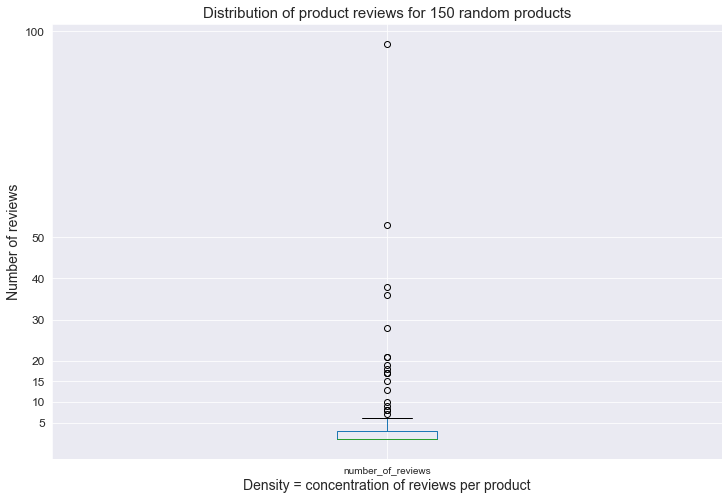

In [26]:
plt.figure(figsize=(12,8))
plt.title('Distribution of product reviews for 150 random products', size=15)
plt.yticks([5, 10, 15, 20, 30, 40, 50, 100], size = 12)
plt.ylabel('Number of reviews', size=14)
plt.xlabel('Density = concentration of reviews per product', size=14)
ecom['number_of_reviews'][:150].plot(kind='box');
plt.savefig('../assets/concentration_reviews.jpg')

In [27]:
#map no. reviews vs. no customer q's as ratio
#ecom['review_to_q_ratio'] = ecom['number_of_reviews']/ecom['number_of_answered_questions'] + 1
#pd.DataFrame(ecom['review_to_q_ratio'].value_counts())[:15]

#NOTE: while the ratio works fine, we are abandoning this calculation / metric
#due to introduction of division by 0, which creates problems downstream.

### Products

In [28]:
pd.DataFrame(ecom['product_name'].value_counts())

,product_name
Polyhedral Dice,3
Zoo Animal Hand Sock Glove Finger Puppets Sack Plush Toy Cow,3
Tofern ® Syma 2015 Edition S107E/S107W New Version 3.5 Channel RC Indoor Helicopter with Gyro ~ Blue,2
Orchard Toys Farmyard Dominoes,2
Iron Man 3 Marvel Iron Assemblers Battle Vehicle,2
...,...
The Puppet Company - Time For Story - Witch Hand Puppet,1
"Teddy Bear with chameleon, limb, slither, animal, reptile image t-shirt",1
Motor Zone Motorhome,1
Tyrannosaurus- 4D Puzzle,1


### Categories

_It should be noted that this may not be a complete representation of Amazon's product categories since it is unknown if any filters were used during the scrape or preparation of the data sample._

In [29]:
#categories

cats = pd.DataFrame(
    ecom['amazon_category_and_sub_category'].value_counts())
print(cats.count())
cats[:50]

amazon_category_and_sub_category    256
dtype: int64


,amazon_category_and_sub_category
Die-Cast & Toy Vehicles > Toy Vehicles & Accessories > Scaled Models > Vehicles,880
,684
Figures & Playsets > Science Fiction & Fantasy,483
Arts & Crafts > Children's Craft Kits > Bead Art & Jewellery-Making,368
Characters & Brands > Disney > Toys,346
Hobbies > Trading Cards & Accessories > Packs & Sets,317
Games > Dice & Dice Games,297
Party Supplies > Decorations > Balloons,293
"Party Supplies > Banners, Stickers & Confetti > Banners",278
Games > Card Games,242


_It looks like this dataset favors toys. It is possible -- since we do not have the methodology used during scraping availed to us -- that the products have already been filtered for specific categories._

In [30]:
#Do certain categories rank higher than others? - can also SPIDER CHART THIS!
q = """
    SELECT DISTINCT amazon_category_and_sub_category AS category,
        average_review_rating AS star_rating
           FROM df
           WHERE star_rating <> 0
           GROUP BY category
           ORDER BY star_rating DESC
              
"""

rating_by_cat = pd.DataFrame(pysqldf(q))

print('Top rated categories')
rating_by_cat.set_index('category')[:15]

Top rated categories


,star_rating
category,
"Sports Toys & Outdoor > Bikes, Trikes & Ride-ons > Children's Bikes",4.9
"Party Supplies > Banners, Stickers & Confetti > Garlands",4.9
"Party Supplies > Banners, Stickers & Confetti > Confetti",4.9
"Hobbies > Slot Cars, Race Tracks & Accessories > Slot Cars",4.9
"Hobbies > Slot Cars, Race Tracks & Accessories > Service & Tuning Parts",4.9
Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains,4.9
Hobbies > Model Building Kits,4.9
Games > Casino Equipment > Game Layouts > Poker Layouts,4.9
Games > Casino Equipment > Bingo Equipment,4.9


In [31]:
print('Lowest rated categories')
rating_by_cat.set_index('category').tail(15)

Lowest rated categories


,star_rating
category,
Characters & Brands > Harry Potter > Toys,4.0
Characters & Brands > Crayola,4.0
Characters & Brands > Barbie > Barbie Dolls & Accessories,4.0
Characters & Brands > Barbie,4.0
Characters & Brands > Action Man > Toys,4.0
Baby & Toddler Toys > Rattles,4.0
Baby & Toddler Toys > Pushchair Toys,4.0
Arts & Crafts > Paper & Stickers,4.0
Arts & Crafts > Drawing & Painting Supplies > Paints > Poster Paints,4.0


### Manufacturers

In [32]:
#manufs
manufs = pd.DataFrame(ecom['manufacturer'].value_counts())
print(manufs.count())
manufs[:25]

manufacturer    2646
dtype: int64


,manufacturer
LEGO,171
Disney,167
Oxford Diecast,156
Playmobil,144
Star Wars,120
Mattel,114
Hasbro,110
The Puppet Company,109
MyTinyWorld,93
Corgi,90


_As with categories, we see a predominance / prepondrance of gaming items here._

### Price

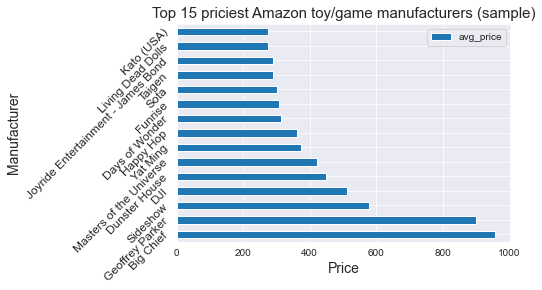

In [33]:
#look at price per manuf
def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())

df = ecom


q = """
    SELECT DISTINCT manufacturer, AVG(median_sale_price) AS avg_price
           FROM df
           GROUP BY manufacturer
           ORDER BY avg_price DESC
              
"""

price_by_manuf = pd.DataFrame(pysqldf(q))

price_by_manuf.set_index(
    'manufacturer')[:15].plot(kind = 'barh');
plt.title(
    'Top 15 priciest Amazon toy/game manufacturers (sample)',
size=15)
plt.xlabel('Price', size=14);
plt.ylabel('Manufacturer', size=14)
plt.yticks(size=12, rotation=45);
plt.savefig('../assets/top_manuf_by_price.jpg')

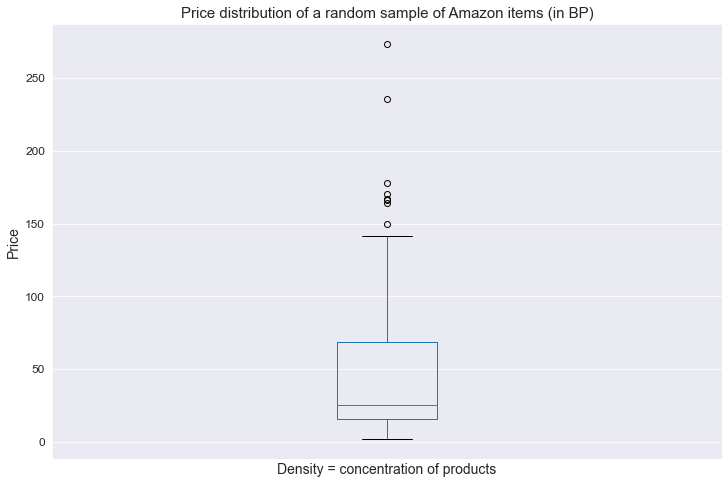

In [34]:
#price dist -- although might be more meaningful to do per category or manuf
plt.figure(figsize=(12,8))
ecom['price'][:150].plot(kind='box');
plt.xticks([]);
plt.ylabel('Price', size = 14)
plt.yticks(size=12)
plt.xlabel('Density = concentration of products', size=14)
plt.title('Price distribution of a random sample of Amazon items (in BP)', size=15);
plt.savefig('../assets/price_concentrate.jpg')

### New vs used items

NOTE: this is the number of product listings that show at least one new and at least one used product.

In [35]:
ecom['number_available_in_stock'].value_counts()[:10]
#replace w/ a search for ~like new, ~like used, and then get a count: use `string.find()`

#Gwen: use `str.contains()` rather than `str.find`, which looks for index

new = ecom['number_available_in_stock'].str.contains('new').sum()
used = ecom['number_available_in_stock'].str.contains('used').sum()

print(f'There are {new} new items sold and {used} used')

There are 7309 new items sold and 161 used


The vast majority of our products are comprised of new items, so this may not be a particularly indicative feature worth splitting on.

### Sellers

In [36]:
#count of sellers
ecom.groupby(['sellers']).count() #REDO this as a dict comp if desired

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,median_sale_price
sellers,,,,,,,,,,,,,,,,,
,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£0.38""}, {""Seller_name_2""=>""M and N Media US"", ""Seller_price_2""=>""£48.97""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£1.95""}, {""Seller_name_2""=>""Amazon.co.uk"", ""Seller_price_2""=>""£6.99""}, {""Seller_name_3""=>""a1 Toys"", ""Seller_price_3""=>""£11.32""}, {""Seller_name_4""=>""Beanie Games"", ""Seller_price_4""=>""£6.99""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£10.34""}, {""Seller_name_2""=>""ARGOSYTOYS home delivery service UK and Worldwide. Established 1947."", ""Seller_price_2""=>""£14.97""}, {""Seller_name_3""=>""DALY store"", ""Seller_price_3""=>""£52.95""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£12.95""}, {""Seller_name_2""=>""Firestorm Cards"", ""Seller_price_2""=>""£21.99""}, {""Seller_name_3""=>""M and N Media US"", ""Seller_price_3""=>""£23.54""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"{""seller""=>{""Seller_name_1""=>""verkauf1"", ""Seller_price_1""=>""£69.99""}}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>{""Seller_name_1""=>""verkauf1"", ""Seller_price_1""=>""£74.99""}}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>{""Seller_name_1""=>""verkauf1"", ""Seller_price_1""=>""£90.99""}}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [37]:
##Gwen's code - number of different sellers for a single product:
ecom['sellers'][0].split('Seller_price_')[-1][0]

'5'

In [38]:
#Gwen's code
# all the prices for a single item
# map to create column
[float(x.split(
    '"')[0].replace(
    "'",'')) for x in ecom['sellers'][0].split('£')[1:]]

[3.42, 0.19, 9.99, 8.0, 37.62]

Noting here that the wild price ranges may reflect the different product conditions, although this is purely an assumption. We are not looking at quality control around price gauging and such issues as part of this problem statement at the moment.

In [39]:
#to be revisited for future consideration: no. of reviews per seller

### Relationships

The heart of what we want to determine assumes a strong relationship between various product facets / metadata and ratings. Let's get some early validation of this assumption.

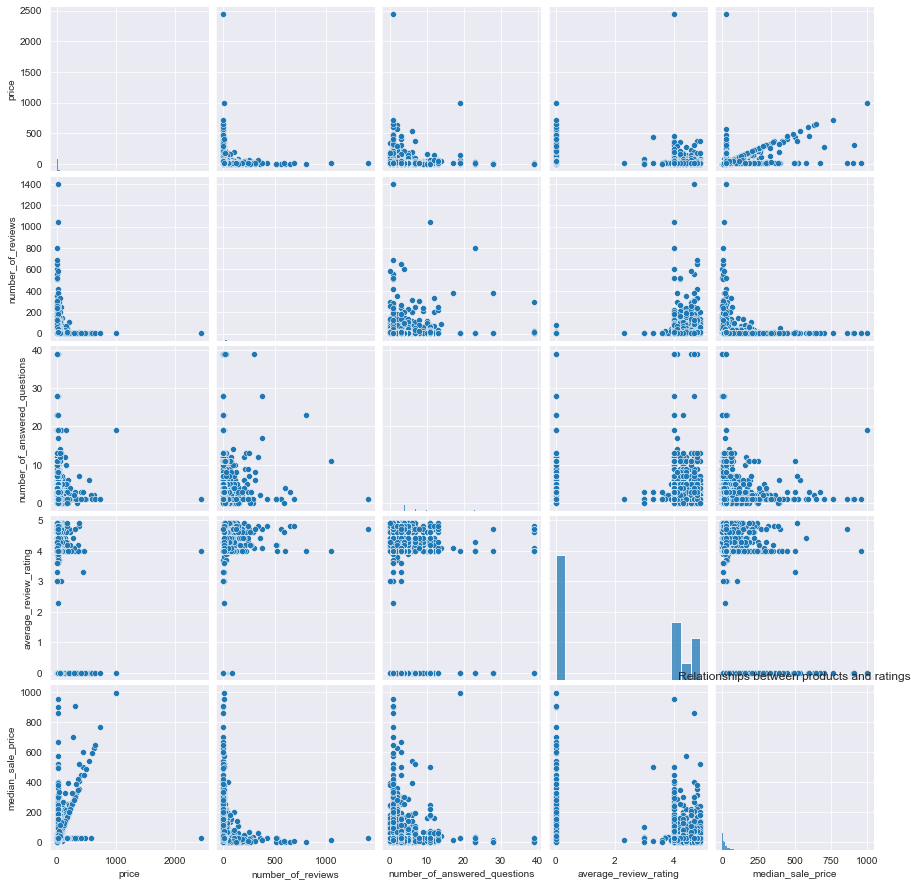

In [40]:
sns.pairplot(data=ecom) #, hue ='average_review_rating');
plt.title('Relationships between products and ratings')
plt.savefig('../assets/pairplot.jpg')

It looks like we see no discnernable patterns from a pairplot at this point.
Let's get at the same from a different angle, using correlation analysis.

In [41]:
#corr
corr = ecom.corr()
corr.round(2)

,price,number_of_reviews,number_of_answered_questions,average_review_rating,median_sale_price
price,1.00,-0.02,0.01,-0.05,0.51
number_of_reviews,-0.02,1.00,0.11,0.24,-0.02
number_of_answered_questions,0.01,0.11,1.00,0.04,0.02
average_review_rating,-0.05,0.24,0.04,1.00,-0.03
median_sale_price,0.51,-0.02,0.02,-0.03,1.00


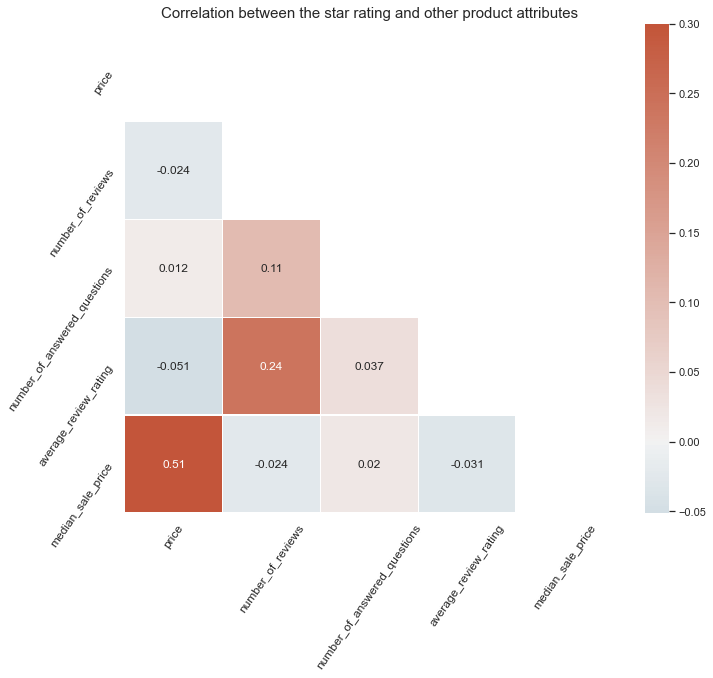

In [42]:
#corr plot
#ref from https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True, linewidths=.5)

plt.title(
    'Correlation between the star rating and other product attributes',
size = 15);
plt.xticks(size=12, rotation=55);
plt.yticks(size=12, rotation = 55);
plt.savefig('../assets/Corr.jpg');

Unfortunately, this only confirms the lack of correlation, albeit we are greatly limited here by having only numerical data represented at the moment. We will need to dig deeper, once we have some discernable vectorized text and categorical data.


## Feature engineering

We need to encode some columns so that the modeling can work correctly.

The plan:

* The ratings column is our target
* We need to categorize products, manufacturers and categories

In [43]:
#current shape
ecom.shape

(9982, 18)

In [44]:
#one-hot encode manufs, product name and product categories

ecom = pd.get_dummies(ecom, columns = [
    'product_name', #products
    'manufacturer', #manufs
    'amazon_category_and_sub_category' #product categories
],drop_first=True)

# Caution--big printout!!
ecom.head().T

,0,1,2,3,4
uniq_id,eac7efa5dbd3d667f26eb3d3ab504464,b17540ef7e86e461d37f3ae58b7b72ac,348f344247b0c1a935b1223072ef9d8a,e12b92dbb8eaee78b22965d2a9bbbd9f,e33a9adeed5f36840ccc227db4682a36
price,3.42,16.99,9.99,39.99,32.19
number_available_in_stock,5 new,,2 new,,
number_of_reviews,15,2,17,1,3
number_of_answered_questions,1,1,2,2,2
...,...,...,...,...,...
"amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate > Bars > Multipack Bars",0,0,0,0,0
amazon_category_and_sub_category_Women > Accessories,0,0,0,0,0
amazon_category_and_sub_category_Women > Accessories > Eyewear & Accessories > Sunglasses,0,0,0,0,0
amazon_category_and_sub_category_Women > Tops & T-Shirts,0,0,0,0,0


In [45]:
#NOW check shape...
ecom.shape

(9982, 12861)

In [48]:
ecom.head(2).T

,0,1
uniq_id,eac7efa5dbd3d667f26eb3d3ab504464,b17540ef7e86e461d37f3ae58b7b72ac
price,3.42,16.99
number_available_in_stock,5 new,
number_of_reviews,15,2
number_of_answered_questions,1,1
...,...,...
"amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate > Bars > Multipack Bars",0,0
amazon_category_and_sub_category_Women > Accessories,0,0
amazon_category_and_sub_category_Women > Accessories > Eyewear & Accessories > Sunglasses,0,0
amazon_category_and_sub_category_Women > Tops & T-Shirts,0,0


## Export df

In [46]:
ecom.to_csv(r'../data/ecom.csv', index=False)

_This notebook continues [here](../code/Amazon-product-catalog-NLP-modeling.ipynb)._